# **Lab 2: Linear Regression**








The purpose of this lab is to apply a simple machine learning method, namely *linear regression*, to some regression and classification tasks on two popular data sets. We will show how linear regression may differ when used to solve a regression or classification problem. As we know, linear regression is simple enough so that we can derive the closed-form solution to solve it. In this project, we will use both the closed-form method and an iterative gradient descent method (e.g. minibatch SGD) to solve linear regression for these tasks and compare their pros and cons in practice. Moreover, we will use linear regression as a simple example to explain some fine-tuning tricks when using any iterative optimization methods (e.g. SGD) in machine learning. As we will see in the up-coming projects, these tricks become vital in learning large models in machine learning, such as deep neural networks. 

*Prerequisites*: N/A

## **I. Linear Regression for Regression**


### **Example 2.1:**

Use linear regression to predict house prices in the popular [Boston House data set](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). Consider to use both the closed-form solution and an iterative method to fit to the data and discuss their pros and cons with some experimental results. 

In [1]:
# load Boston House data set
import pandas as pd
import numpy as np

raw_data = pd.read_csv('boston.csv', header=None)
data_rows = np.reshape(raw_data.to_numpy(), (506,14))
data = data_rows[:,:13]
target = data_rows[:,13]

# normalize input features to zero-mean and unit-variance
data = (data-np.mean(data, axis=0))/np.std(data, axis=0) 

print(data.shape)
print(target.shape)

(506, 13)
(506,)


Use the closed-form solution of normal equations $$\mathbf{w}^{\ast} = \left(\mathbf{X^TX}\right)^{-1}\mathbf{X}^T\mathbf{y}$$

In [2]:
# add a constant column of '1' to accomodate the bias 
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))

print(data_wb.shape)

# refer to the closed-form solution
w = np.linalg.inv(data_wb.T @ data_wb) @ data_wb.T @ target

# calculate the mean square error in the training set
predict = data_wb @ w 
error = np.sum((predict - target)*(predict - target))/data.shape[0]

print(f'mean square error for the closed-form solution: {error:.3f}')
print(w)

(506, 14)
mean square error for the closed-form solution: 21.895
[-9.28146064e-01  1.08156863e+00  1.40899997e-01  6.81739725e-01
 -2.05671827e+00  2.67423017e+00  1.94660717e-02 -3.10404426e+00
  2.66221764e+00 -2.07678168e+00 -2.06060666e+00  8.49268418e-01
 -3.74362713e+00  2.25328063e+01]


Consider to solve the above linear regression using an iterative optimization, such as gradient descent.

The popular criterion to estimate the target function is to minimize the total
square error in a given training set. The objective function in linear regression, i.e. the mean square error (MSE), is given as:
\begin{eqnarray}
E(\mathbf{w}) & = & \frac{1}{2} \sum_{i=1}^N \big( \mathbf{w}^\intercal \mathbf{x}_i - y_i \big)^2  \nonumber \\
& = & \frac{1}{2} \Big(
\mathbf{w}^\intercal \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - 2 \mathbf{w}^\intercal  \mathbf{X} ^\intercal  \mathbf{y} + \mathbf{y}^\intercal \mathbf{y} \Big)\nonumber
\end{eqnarray}
we can show that its gradient can be computed in several equivallent ways as follows:
\begin{eqnarray}
\frac{\partial E(\mathbf{w})}{ \partial \mathbf{w} } 
& = & \sum_{i=1}^ N  \big( \mathbf{w}^\intercal \mathbf{x}_i - y_i \big) \mathbf{x}_i 
= \sum_{i=1}^ N  \mathbf{x}_i  \big( \mathbf{x}_i^\intercal \mathbf{w} - y_i \big) 
\nonumber \\
& = & \Big( \sum_{i=1}^N  \mathbf{x}_i \mathbf{x}_i^ \intercal \Big) \mathbf{w} - \sum_{i=1}^N  y_i \mathbf{x}_i \nonumber \\
& = &  \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - \mathbf{X} ^\intercal  \mathbf{y}
\end{eqnarray}
where $\mathbf{X}$ and $\mathbf{y}$ are defined in the same way. 

In the following, we use the formula from last row to calculate gradients via vectorization. Furthermore, we  implement a mini-batch SGD to learn linear regression iteratively. 

In [3]:
# solve linear regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer 
def linear_regression_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors

In [4]:
op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500)

w, errors = linear_regression_gd(data_wb, target,op)

epoch=0: the mean square error is 568.0435472742349
epoch=1: the mean square error is 545.8364914610414
epoch=2: the mean square error is 525.4227582536355
epoch=3: the mean square error is 506.47623085622433
epoch=4: the mean square error is 488.74389142007885
epoch=5: the mean square error is 472.1227651472534
epoch=6: the mean square error is 456.44886922569594
epoch=7: the mean square error is 441.7413369966778
epoch=8: the mean square error is 427.8402048568325
epoch=9: the mean square error is 414.63304694919816
epoch=10: the mean square error is 402.12456472617026
epoch=11: the mean square error is 390.2029030884604
epoch=12: the mean square error is 378.82334218414957
epoch=13: the mean square error is 367.9580480665025
epoch=14: the mean square error is 357.566702553113
epoch=15: the mean square error is 347.66050547546854
epoch=16: the mean square error is 338.1686882422439
epoch=17: the mean square error is 329.078328733458
epoch=18: the mean square error is 320.326587160094

epoch=189: the mean square error is 52.9866413729595
epoch=190: the mean square error is 52.83899524890515
epoch=191: the mean square error is 52.69311845501085
epoch=192: the mean square error is 52.549822368643774
epoch=193: the mean square error is 52.408666602637695
epoch=194: the mean square error is 52.26961748355568
epoch=195: the mean square error is 52.13274573270719
epoch=196: the mean square error is 51.997901012193076
epoch=197: the mean square error is 51.86487057199475
epoch=198: the mean square error is 51.734074112489246
epoch=199: the mean square error is 51.60437743321022
epoch=200: the mean square error is 51.47703708656137
epoch=201: the mean square error is 51.35149396032123
epoch=202: the mean square error is 51.22752594031154
epoch=203: the mean square error is 51.105361558805434
epoch=204: the mean square error is 50.98512555933726
epoch=205: the mean square error is 50.86648038533673
epoch=206: the mean square error is 50.74982116047424
epoch=207: the mean squa

epoch=459: the mean square error is 41.93691905833083
epoch=460: the mean square error is 41.93077684186284
epoch=461: the mean square error is 41.924691185222166
epoch=462: the mean square error is 41.91865761598346
epoch=463: the mean square error is 41.91271329975846
epoch=464: the mean square error is 41.90681019164258
epoch=465: the mean square error is 41.90097255343666
epoch=466: the mean square error is 41.89515448647308
epoch=467: the mean square error is 41.889425291473046
epoch=468: the mean square error is 41.88374631183632
epoch=469: the mean square error is 41.878147182487346
epoch=470: the mean square error is 41.87260263280613
epoch=471: the mean square error is 41.86710073347371
epoch=472: the mean square error is 41.86167296807674
epoch=473: the mean square error is 41.8562982474551
epoch=474: the mean square error is 41.85098786206371
epoch=475: the mean square error is 41.84571777349088
epoch=476: the mean square error is 41.8404922042092
epoch=477: the mean square 

epoch=0: the mean square error is 568.0326466617794
epoch=1: the mean square error is 545.9084350581638
epoch=2: the mean square error is 525.4808613596078
epoch=3: the mean square error is 506.5337028873719
epoch=4: the mean square error is 488.8242210752911
epoch=5: the mean square error is 472.22912760740957
epoch=6: the mean square error is 456.5791678756926
epoch=7: the mean square error is 441.8356051128643
epoch=8: the mean square error is 427.9387379439912
epoch=9: the mean square error is 414.7352761805738
epoch=10: the mean square error is 402.2098140005759
epoch=11: the mean square error is 390.2811939711981
epoch=12: the mean square error is 378.8894463348075
epoch=13: the mean square error is 368.0557292234814
epoch=14: the mean square error is 357.67001122244903
epoch=15: the mean square error is 347.75236281474633
epoch=16: the mean square error is 338.2527286206476
epoch=17: the mean square error is 329.1494655074916
epoch=18: the mean square error is 320.39222394028565

epoch=318: the mean square error is 43.97582522929453
epoch=319: the mean square error is 43.94763437846021
epoch=320: the mean square error is 43.91979632901611
epoch=321: the mean square error is 43.89223866969898
epoch=322: the mean square error is 43.8650119483844
epoch=323: the mean square error is 43.838132186158944
epoch=324: the mean square error is 43.811510005960145
epoch=325: the mean square error is 43.78523620745165
epoch=326: the mean square error is 43.75914696701635
epoch=327: the mean square error is 43.733448722208855
epoch=328: the mean square error is 43.708026048280324
epoch=329: the mean square error is 43.682962164531936
epoch=330: the mean square error is 43.658125229237996
epoch=331: the mean square error is 43.63345107620666
epoch=332: the mean square error is 43.60909681371078
epoch=333: the mean square error is 43.58510048260593
epoch=334: the mean square error is 43.56128518371045
epoch=335: the mean square error is 43.537725230567304
epoch=336: the mean sq

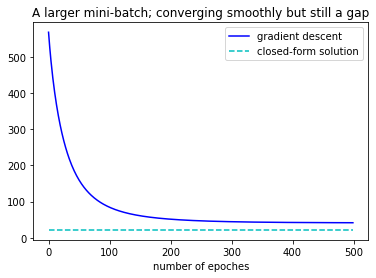

In [5]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('A larger mini-batch; converging smoothly but still a gap')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

epoch=0: the mean square error is 346.73692627194123
epoch=1: the mean square error is 217.59749726784443
epoch=2: the mean square error is 141.24340937850323
epoch=3: the mean square error is 95.45093550388607
epoch=4: the mean square error is 67.68108788420328
epoch=5: the mean square error is 50.776610789133215
epoch=6: the mean square error is 40.52985595929586
epoch=7: the mean square error is 34.06877283343214
epoch=8: the mean square error is 30.04615239044902
epoch=9: the mean square error is 27.529777799651367
epoch=10: the mean square error is 25.90682472081109
epoch=11: the mean square error is 24.935413856558938
epoch=12: the mean square error is 24.203477725526078
epoch=13: the mean square error is 23.759889807587324
epoch=14: the mean square error is 23.478060509710645
epoch=15: the mean square error is 23.250240749252796
epoch=16: the mean square error is 23.081507472634016
epoch=17: the mean square error is 22.955196625569158
epoch=18: the mean square error is 22.863541

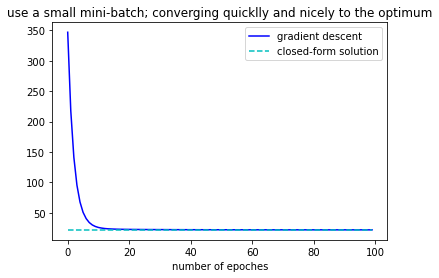

In [6]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=2, max_epochs=100)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('use a small mini-batch; converging quicklly and nicely to the optimum')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

epoch=0: the mean square error is 343.392268280547
epoch=1: the mean square error is 211.54634776665208
epoch=2: the mean square error is 136.640131029625
epoch=3: the mean square error is 92.02747318491502
epoch=4: the mean square error is 64.82010587115626
epoch=5: the mean square error is 48.798015734678664
epoch=6: the mean square error is 38.88958080494364
epoch=7: the mean square error is 32.93366057507034
epoch=8: the mean square error is 29.3723790066839
epoch=9: the mean square error is 27.000815072099986
epoch=10: the mean square error is 25.465752934772688
epoch=11: the mean square error is 24.58382822431952
epoch=12: the mean square error is 24.00579166310445
epoch=13: the mean square error is 23.616508346231463
epoch=14: the mean square error is 23.374544189895868
epoch=15: the mean square error is 23.206347906717802
epoch=16: the mean square error is 23.125621115156772
epoch=17: the mean square error is 22.964993397739768
epoch=18: the mean square error is 22.843476259275

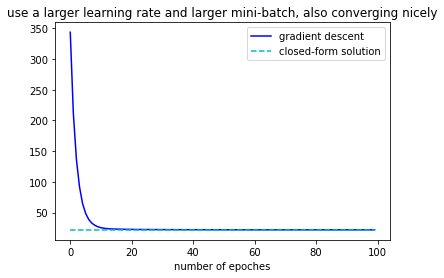

In [7]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.01, annealing_rate=0.99, batch_size=20, max_epochs=100)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('use a larger learning rate and larger mini-batch, also converging nicely')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

epoch=0: the mean square error is 22.86366066835723
epoch=1: the mean square error is 28.733495975250953
epoch=2: the mean square error is 27.389785499059634
epoch=3: the mean square error is 24.312842510299134
epoch=4: the mean square error is 23.26658763343031
epoch=5: the mean square error is 23.766581582358377
epoch=6: the mean square error is 28.811410354355967
epoch=7: the mean square error is 35.19566126897413
epoch=8: the mean square error is 25.777601319002038
epoch=9: the mean square error is 23.256974229538876
epoch=10: the mean square error is 22.933274768592653
epoch=11: the mean square error is 81.86877458409464


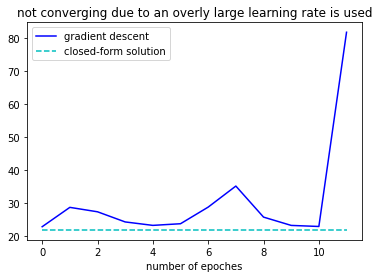

In [8]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.2, annealing_rate=0.99, batch_size=20, max_epochs=12)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('not converging due to an overly large learning rate is used')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

Finally, let us show how to solve the above linear regression problem using the scikit-learning implmenetation. 

In [9]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
l_regr = linear_model.LinearRegression()

# Train the model using the training set
l_regr.fit(data_wb, target)

# Make predictions using the same training set
predict = l_regr.predict(data_wb)

# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(target, predict))

C:\Users\PC\ProgramData\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Mean squared error: 21.89483


## **II. Linear Regression for Classification**

### **Example 2.2:**

Use linear regression to build a binary classifier to classify two digits ('3' and '8') in the MNIST data set. Consider to use both the closed-form solution and an iterative method to fit to the data and discuss their pros and cons with experimental results.

In [10]:
# install python_mnist

!pip install python_mnist

In [16]:
#load MINST images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [17]:
# prepare digits '3' and '8' for linear regression

digit_train_index = np.logical_or(train_label == 3, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 3, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# convert labels: '3' => -1, '8' => +1
CUTOFF = 5 # any number between '3' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

print(X_train.shape)
print(y_train)

print(X_test.shape)
print(y_test)

(11982, 785)
[-1 -1 -1 ...  1 -1  1]
(1984, 785)
[-1 -1 -1 ... -1  1 -1]


In [19]:
# use the closed-form solution

# refer to the closed-form solution, i.e. Eq.(6.9) on page 112
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.19595
classification accuracy on training data for the closed-form solution: 97.05%
mean square error on test data for the closed-form solution: 0.66151
classification accuracy on test data for the closed-form solution: 96.07%


In [20]:
# use linear regression from sklearn

import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
l_regr = linear_model.LinearRegression()

# Train the model using the training set
l_regr.fit(X_train, y_train)

# Make predictions using the same training set
predict = l_regr.predict(X_train)
print("Mean squared error on training data: %.5f" % mean_squared_error(y_train, predict))

# Make predictions using the test set
predict = l_regr.predict(X_test)
print("Mean squared error on test data: %.5f" % mean_squared_error(y_test, predict))

Mean squared error on training data: 0.19595
Mean squared error on test data: 0.66151


Next, let us consider to use mini-batch stochastic gradient descent (SGD) to learn linear regression models for this binary classification problem. When we fine-tune any SGD method for a classificaion problem in machline learning, it is very important to monitor the following three learning curves:

1.   *Classification Accuracy on the training set* (**curve A**): this is the goal of the empirical risk mininization (ERM) of the zero-one loss for classification (see Eq.(5.6) on page 99).  

2.  *Classification Accuracy on an unseen test/development set* (**curve B**): we need to compare the curves **A** and **B** over the learning course to monitor whether overfitting or underfit occurs. Overfitting happens when the gap between **A** and **B** is overly big while underfitting happens when **A** and **B** get very close and both of them yield fairly poor performance. Moreover, we can also monitor the curves  **A** and **B**  to determine when to terminate the learning proces for the best possible performance on the test/devopement set. 

3.  *The value of the learning objective function* (**curve C**): because the zero-one loss is not directly minimizable, we will have to establish a proxy objective function according to some criteria (see Tabe 7.1 on page 135). These objective functions are closelly related to the zero-one loss but they are NOT the same. When we fine-tune an iterative optimization method, the first thing is to ensure that the value of the chosen objective function descreases over the entire learning course. If we cannot reduce the objective function (even when a sufficiently small learning rate is used), it is very likely that the implementation or code is buggy. Furthermore, if curve **C** is going down while curve **A** is not going up, this is another indicator that someting is still wrong in the implementation. 


In [21]:
# solve linear regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def linear_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0] 

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n   

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.398 (0.910,0.920)
epoch=1: the mean square error is 0.309 (0.929,0.943)
epoch=2: the mean square error is 0.279 (0.939,0.952)
epoch=3: the mean square error is 0.263 (0.944,0.957)
epoch=4: the mean square error is 0.254 (0.949,0.960)
epoch=5: the mean square error is 0.248 (0.951,0.962)
epoch=6: the mean square error is 0.243 (0.952,0.963)
epoch=7: the mean square error is 0.240 (0.954,0.963)
epoch=8: the mean square error is 0.237 (0.955,0.964)
epoch=9: the mean square error is 0.235 (0.956,0.964)
epoch=10: the mean square error is 0.234 (0.957,0.963)
epoch=11: the mean square error is 0.232 (0.957,0.963)
epoch=12: the mean square error is 0.231 (0.958,0.964)
epoch=13: the mean square error is 0.230 (0.958,0.964)
epoch=14: the mean square error is 0.229 (0.959,0.964)
epoch=15: the mean square error is 0.228 (0.959,0.963)
epoch=16: the mean square error is 0.227 (0.959,0.963)
epoch=17: the mean square error is 0.226 (0.960,0.964)
epoch=18: the mean s

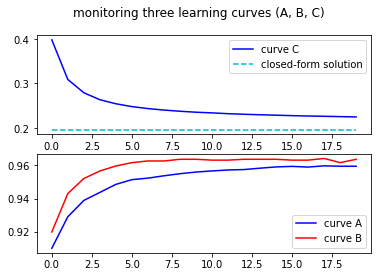

In [22]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

In the above setting, we use a large mini-batch (50), which leads to fairly smooth convergence. As we can see, even though there is a big gap in the objective function between SGD (curve C) and the closed-form solution, classification accuracy of SGD  exceeds that of the closed-form solution on either the training or  testing set. This indicates that MSE used in linear regression is NOT a good learning criterion for classification (see why in section 7.1.1 on page 136).

epoch=0: the mean square error is 0.235 (0.957,0.964)
epoch=1: the mean square error is 0.226 (0.959,0.961)
epoch=2: the mean square error is 0.220 (0.961,0.963)
epoch=3: the mean square error is 0.219 (0.961,0.965)
epoch=4: the mean square error is 0.217 (0.962,0.964)
epoch=5: the mean square error is 0.214 (0.962,0.962)
epoch=6: the mean square error is 0.214 (0.962,0.963)
epoch=7: the mean square error is 0.212 (0.963,0.965)
epoch=8: the mean square error is 0.212 (0.964,0.963)
epoch=9: the mean square error is 0.211 (0.964,0.964)


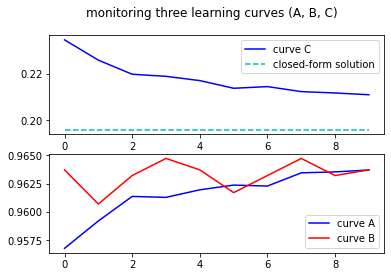

In [23]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=5, max_epochs=10)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

In this setting, we use the same learning rate but a much smaller mini-batch size. A smaller mini-batch means more model updates in each epoch. As a result, the classification accuracy on the training set (curve **A**) is improved over the previous setting. However, we can see that the classification accuracy on the unseen set (curve **B**) starts to go down after epoch 6, which indicates that we should terminate the learning at epoch 6. 

## **Exercises**

### **Problem 2.1:**

Use Ridge regression to solve the regression problem in Example 2.1 as well as the classification problem in Example 2.2, also implement both closed-form and iterative approachs, compare the results of Ridge regression with those of linear regression.

## **I. Ridge Regression for Regression**


Use the closed-form solution of normal equations $$\mathbf{w}^{\ast} = \left(\mathbf{X^TX +\lambda.I}\right)^{-1}\mathbf{X}^T\mathbf{y}$$

In [82]:
# add a constant column of '1' to accomodate the bias 
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))

print(data_wb.shape)
class ridge:
    def __init__(self,alpha):
        self.alpha=alpha
        self.coef_=None
        self.intercept_=None
    def fit(self,X,y):
        X=np.insert(X,0,1,axis=1)
        I=np.identity(X.shape[1])
        I[0][0]=0
        # refer to the closed-form solution
        w = np.linalg.inv((X.T @ X)+self.alpha*I) @ X.T @ y
        self.intercept_=w[0]
        self.coef_=w[1:]
        return self.intercept_ , self.coef_
    def predict(self,X,y):
        # calculate the mean square error in the training set
        predict = (X @ self.coef_)+self.intercept_
        error = np.sum((predict - y)*(predict - y))/X.shape[0]
        return error

(506, 14)


In [84]:
Ridge=ridge(alpha=0.001)
print(Ridge.fit(data_wb,target))
print(Ridge.predict(data_wb,target))

(22.53280632420041, array([-9.28137599e-01,  1.08155318e+00,  1.40875707e-01,  6.81743226e-01,
       -2.05669013e+00,  2.67423892e+00,  1.94596061e-02, -3.10401732e+00,
        2.66214490e+00, -2.07671325e+00, -2.06059831e+00,  8.49268000e-01,
       -3.74361403e+00, -7.93563252e-10]))
21.894831182808527


Consider to solve the above ridge regression using an iterative optimization, such as gradient descent.

The popular criterion to estimate the target function is to minimize the total
square error in a given training set. The objective function in linear regression, i.e. the mean square error (MSE), is given as:
\begin{eqnarray}
E(\mathbf{w}) & = & \frac{1}{2} \sum_{i=1}^N \big( \mathbf{w}^\intercal \mathbf{x}_i - y_i \big)^2 + \lambda \sum_{i=1}^N \big(   \mathbf{w} \big)^2 \nonumber \\
& = & \frac{1}{2} \Big(
\mathbf{w}^\intercal \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - 2 \mathbf{w}^\intercal  \mathbf{X} ^\intercal  \mathbf{y} + \mathbf{y}^\intercal \mathbf{y} +\lambda \mathbf{w} \Big)\nonumber
\end{eqnarray}
we can show that its gradient can be computed in several equivallent ways as follows:
\begin{eqnarray}
\frac{\partial E(\mathbf{w})}{ \partial \mathbf{w} +\lambda \mathbf{w} } 
& = & \sum_{i=1}^ N  \big( \mathbf{w}^\intercal \mathbf{x}_i - y_i \big) \mathbf{x}_i 
= \sum_{i=1}^ N  \mathbf{x}_i  \big( \mathbf{x}_i^\intercal \mathbf{w} - y_i \big) +\lambda \mathbf{w}
\nonumber \\
& = & \Big( \sum_{i=1}^N  \mathbf{x}_i \mathbf{x}_i^ \intercal \Big) \mathbf{w} - \sum_{i=1}^N  y_i \mathbf{x}_i +\lambda \mathbf{w} \nonumber \\
& = &  \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - \mathbf{X} ^\intercal \mathbf{y} +\lambda \mathbf{w} 
\end{eqnarray}
where $\mathbf{X}$ and $\mathbf{y}$ are defined in the same way. 

In the following, we use the formula from last row to calculate gradients via vectorization. Furthermore, we  implement a mini-batch SGD to learn linear regression iteratively. 

In [97]:
# solve ridge regression using gradient descent 
import numpy as np

class RidgeGD():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs, alpha):
    self.lr=lr
    self.alpha = alpha
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.coef_= None
    self.intercept_=None
  def fit(self,X,y):
    n=X.shape[0]
    self.coef_= np.ones(X.shape[1])
    self.intercept_= 0
    w=np.insert(self.coef_,0,self.intercept_)
    
    X=np.insert(X,0,1,axis=1)
    lr = self.lr
    errors = np.zeros(self.max_epochs)
    for epoch in range(self.max_epochs):
        indices = np.random.permutation(n)  #randomly shuffle data indices
        for batch_start in range(0, n, self.batch_size):
            X_batch = X[indices[batch_start:batch_start + self.batch_size]]
            y_batch = y[indices[batch_start:batch_start + self.batch_size]]

        # vectorization to compute gradients for a whole mini-batch (see the above formula)
            w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch +self.alpha*w
            w= w - self.lr*w_grad/X_batch.shape[0]
      
        self.coef_=w[1:]
        self.intercept_=w[0]
    
        y_predict= X @ w
        diff = y_predict- y  # prediction difference
        errors[epoch] = np.sum(diff*diff)/n
        lr *= self.annealing_rate
        print(f'epoch={epoch}: the mean square error is {errors[epoch]}')
    return  w,errors
    

In [98]:
reg=RidgeGD(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=500, alpha=0.001)
print(reg.fit(data_wb, target))

epoch=0: the mean square error is 572.4497262509283
epoch=1: the mean square error is 542.8654127726601
epoch=2: the mean square error is 515.7378812219201
epoch=3: the mean square error is 490.3068943011276
epoch=4: the mean square error is 465.22784800058116
epoch=5: the mean square error is 443.23008837253246
epoch=6: the mean square error is 422.3006800565391
epoch=7: the mean square error is 403.8283135773439
epoch=8: the mean square error is 386.28450768573487
epoch=9: the mean square error is 368.5602788410784
epoch=10: the mean square error is 352.39002016208434
epoch=11: the mean square error is 337.71558429979086
epoch=12: the mean square error is 323.4304522228873
epoch=13: the mean square error is 310.36220806417685
epoch=14: the mean square error is 298.06263136033914
epoch=15: the mean square error is 285.43920968547405
epoch=16: the mean square error is 273.38754579044735
epoch=17: the mean square error is 262.2255639090212
epoch=18: the mean square error is 251.66826982

epoch=336: the mean square error is 23.636013832639602
epoch=337: the mean square error is 23.62979121641271
epoch=338: the mean square error is 23.624679590070713
epoch=339: the mean square error is 23.61808811383224
epoch=340: the mean square error is 23.61217271913553
epoch=341: the mean square error is 23.604842207808595
epoch=342: the mean square error is 23.59839326640991
epoch=343: the mean square error is 23.59181892494797
epoch=344: the mean square error is 23.586071045325852
epoch=345: the mean square error is 23.57868675741099
epoch=346: the mean square error is 23.570614580913286
epoch=347: the mean square error is 23.56683123147636
epoch=348: the mean square error is 23.56160709168754
epoch=349: the mean square error is 23.55326827362351
epoch=350: the mean square error is 23.545574539258542
epoch=351: the mean square error is 23.54033505463481
epoch=352: the mean square error is 23.536264881477983
epoch=353: the mean square error is 23.529132023195828
epoch=354: the mean 

(array([10.74984805, -0.66148494,  0.60302749, -0.2254449 ,  0.76229263,
       -0.88268327,  3.2777101 , -0.10373769, -1.84808156,  0.9373685 ,
       -0.69127266, -1.77087329,  0.95082566, -3.33582273, 11.74966474]), array([572.44972625, 542.86541277, 515.73788122, 490.3068943 ,
       465.227848  , 443.23008837, 422.30068006, 403.82831358,
       386.28450769, 368.56027884, 352.39002016, 337.7155843 ,
       323.43045222, 310.36220806, 298.06263136, 285.43920969,
       273.38754579, 262.22556391, 251.66826983, 241.42324263,
       232.38767712, 222.73905558, 214.13594475, 205.92944306,
       198.32951584, 190.6287083 , 183.82768502, 177.16368925,
       170.91443613, 164.8314641 , 158.99105932, 153.19621842,
       147.97064283, 142.96324647, 138.20439138, 133.58019667,
       129.16988547, 124.80336146, 120.85450937, 117.04395661,
       113.33875391, 109.64181628, 105.90764487, 102.60036648,
        99.58134088,  96.36312581,  93.46144392,  90.7140089 ,
        88.14549899,  85.

epoch=0: the mean square error is 556.21800376124
epoch=1: the mean square error is 513.8703069531233
epoch=2: the mean square error is 476.1283590661849
epoch=3: the mean square error is 442.4503460553693
epoch=4: the mean square error is 412.0328962322031
epoch=5: the mean square error is 384.73594960055715
epoch=6: the mean square error is 359.8333111345284
epoch=7: the mean square error is 337.1810131433297
epoch=8: the mean square error is 316.5648934332448
epoch=9: the mean square error is 297.71655870827146
epoch=10: the mean square error is 280.42919775831774
epoch=11: the mean square error is 264.5185320704785
epoch=12: the mean square error is 249.8834873736384
epoch=13: the mean square error is 236.35996665886768
epoch=14: the mean square error is 223.8648815197472
epoch=15: the mean square error is 212.31226220071596
epoch=16: the mean square error is 201.55753397767128
epoch=17: the mean square error is 191.5969768734091
epoch=18: the mean square error is 182.3331979502087

epoch=249: the mean square error is 35.81623127610155
epoch=250: the mean square error is 35.81060269360073
epoch=251: the mean square error is 35.80650281354886
epoch=252: the mean square error is 35.80207477813508
epoch=253: the mean square error is 35.79464741144196
epoch=254: the mean square error is 35.794555658765816
epoch=255: the mean square error is 35.79295924646182
epoch=256: the mean square error is 35.78890067288793
epoch=257: the mean square error is 35.78410629690115
epoch=258: the mean square error is 35.78313832121578
epoch=259: the mean square error is 35.78266071968626
epoch=260: the mean square error is 35.77866998630639
epoch=261: the mean square error is 35.76829275723769
epoch=262: the mean square error is 35.76499597411697
epoch=263: the mean square error is 35.756600357603894
epoch=264: the mean square error is 35.75444804140769
epoch=265: the mean square error is 35.746251510060645
epoch=266: the mean square error is 35.74634694101348
epoch=267: the mean squar

epoch=411: the mean square error is 35.51937553827994
epoch=412: the mean square error is 35.51997996674057
epoch=413: the mean square error is 35.5181913171384
epoch=414: the mean square error is 35.5234433811017
epoch=415: the mean square error is 35.52396756600368
epoch=416: the mean square error is 35.52551028062942
epoch=417: the mean square error is 35.52866399020221
epoch=418: the mean square error is 35.5260684957029
epoch=419: the mean square error is 35.52618524983141
epoch=420: the mean square error is 35.525460677245135
epoch=421: the mean square error is 35.52623854779875
epoch=422: the mean square error is 35.530669279746185
epoch=423: the mean square error is 35.52830181150919
epoch=424: the mean square error is 35.52678252220976
epoch=425: the mean square error is 35.52779415016506
epoch=426: the mean square error is 35.52700725631732
epoch=427: the mean square error is 35.527126831672284
epoch=428: the mean square error is 35.52763113387971
epoch=429: the mean square e

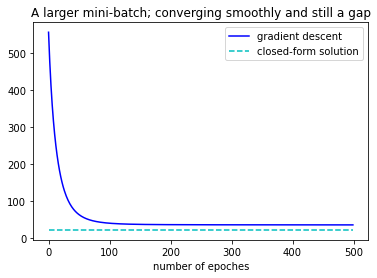

In [93]:
import matplotlib.pyplot as plt

reg=RidgeGD(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500, alpha=10)
w, errors = reg.fit(data_wb, target)
plt.title('A larger mini-batch; converging smoothly and still a gap')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

epoch=0: the mean square error is 214.15650384580493
epoch=1: the mean square error is 96.98893696826988
epoch=2: the mean square error is 53.95202064044598
epoch=3: the mean square error is 37.298155767369096
epoch=4: the mean square error is 30.675935049840593
epoch=5: the mean square error is 27.780437425914332
epoch=6: the mean square error is 26.403166534044544
epoch=7: the mean square error is 25.61232044449218
epoch=8: the mean square error is 25.10183965047014
epoch=9: the mean square error is 24.71934341461057
epoch=10: the mean square error is 24.414060485743576
epoch=11: the mean square error is 24.16100835959261
epoch=12: the mean square error is 23.95064890352566
epoch=13: the mean square error is 23.767384857451262
epoch=14: the mean square error is 23.605793228008846
epoch=15: the mean square error is 23.462100176227995
epoch=16: the mean square error is 23.335400933526422
epoch=17: the mean square error is 23.220149986995686
epoch=18: the mean square error is 23.1332061

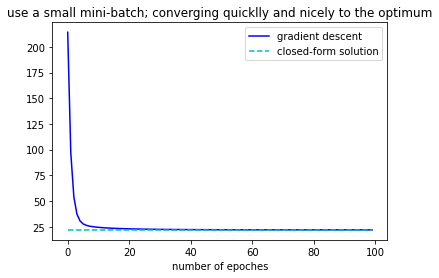

In [95]:
import matplotlib.pyplot as plt

reg=RidgeGD(lr=0.001, annealing_rate=0.99, batch_size=2, max_epochs=100, alpha=0.001)
w, errors = reg.fit(data_wb, target)
plt.title('use a small mini-batch; converging quicklly and nicely to the optimum')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

epoch=0: the mean square error is 205.26636006171077
epoch=1: the mean square error is 92.22107923084477
epoch=2: the mean square error is 51.598285434488645
epoch=3: the mean square error is 35.69218564974632
epoch=4: the mean square error is 29.735519338637594
epoch=5: the mean square error is 27.24091317747706
epoch=6: the mean square error is 25.939039761360203
epoch=7: the mean square error is 25.299370224537896
epoch=8: the mean square error is 24.86495601920597
epoch=9: the mean square error is 24.51650664570164
epoch=10: the mean square error is 24.326144076522045
epoch=11: the mean square error is 23.98392624975575
epoch=12: the mean square error is 23.816462634976826
epoch=13: the mean square error is 23.638644811435956
epoch=14: the mean square error is 23.510227688346856
epoch=15: the mean square error is 23.35454079748865
epoch=16: the mean square error is 23.26581514175198
epoch=17: the mean square error is 23.13795763816199
epoch=18: the mean square error is 23.040896943

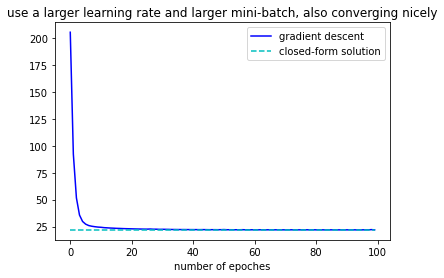

In [96]:
import matplotlib.pyplot as plt

reg=RidgeGD(lr=0.01, annealing_rate=0.99, batch_size=20, max_epochs=100, alpha=0.001)
w, errors = reg.fit(data_wb, target)

plt.title('use a larger learning rate and larger mini-batch, also converging nicely')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

epoch=0: the mean square error is 40.674795056184685
epoch=1: the mean square error is 110.79371006945446
epoch=2: the mean square error is 24.326629719981195
epoch=3: the mean square error is 24.324798324993164
epoch=4: the mean square error is 22.761554264444268
epoch=5: the mean square error is 27.3273591343537
epoch=6: the mean square error is 31.93578617715056
epoch=7: the mean square error is 28.296667551371854
epoch=8: the mean square error is 31.548836954053908
epoch=9: the mean square error is 23.974329199806437
epoch=10: the mean square error is 22.89847893884795
epoch=11: the mean square error is 28.566124893461662


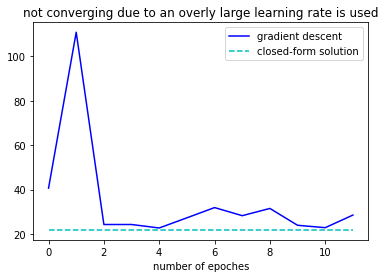

In [99]:
import matplotlib.pyplot as plt
reg=RidgeGD(lr=0.2, annealing_rate=0.99, batch_size=20, max_epochs=12, alpha=0.001)
w, errors = reg.fit(data_wb, target)

plt.title('not converging due to an overly large learning rate is used')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

Finally, let us show how to solve the above ridge regression problem using the scikit-learning implmenetation. 

In [46]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
r_regr = linear_model.Ridge(alpha=0.01)

# Train the model using the training set
r_regr.fit(data_wb, target)

# Make predictions using the same training set
predict = r_regr.predict(data_wb)

# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(target, predict))

Mean squared error: 21.89483


## **II. Linear Regression for Classification**

### **Problem 2.1:**

Use ridge regression to build a binary classifier to classify two digits ('3' and '8') in the MNIST data set. Consider to use both the closed-form solution and an iterative method to fit to the data and discuss their pros and cons with experimental results.

In [101]:
# use the closed-form solution

# refer to the closed-form solution
alpha=0.01
I=np.identity(X_train.shape[1])
I[0][0]=0
w = np.linalg.inv((X_train.T @ X_train) + alpha*I) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.19894
classification accuracy on training data for the closed-form solution: 96.80%
mean square error on test data for the closed-form solution: 0.22920
classification accuracy on test data for the closed-form solution: 96.07%


In [66]:
# use ridge regression from sklearn

import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create ridge regression object
r_regr = linear_model.Ridge(alpha=100)

# Train the model using the training set
r_regr.fit(X_train, y_train)

# Make predictions using the same training set
predict = r_regr.predict(X_train)
print("Mean squared error on training data: %.5f" % mean_squared_error(y_train, predict))

# Make predictions using the test set
predict = r_regr.predict(X_test)
print("Mean squared error on test data: %.5f" % mean_squared_error(y_test, predict))

Mean squared error on training data: 0.20648
Mean squared error on test data: 0.21210


Next, let us consider to use mini-batch stochastic gradient descent (SGD) to learn rigid regression models for this binary classification problem. When we fine-tune any SGD method for a classificaion problem in machline learning, it is very important to monitor the following three learning curves:

1.   *Classification Accuracy on the training set* (**curve A**): this is the goal of the empirical risk mininization (ERM) of the zero-one loss for classification (see Eq.(5.6) on page 99).  

2.  *Classification Accuracy on an unseen test/development set* (**curve B**): we need to compare the curves **A** and **B** over the learning course to monitor whether overfitting or underfit occurs. Overfitting happens when the gap between **A** and **B** is overly big while underfitting happens when **A** and **B** get very close and both of them yield fairly poor performance. Moreover, we can also monitor the curves  **A** and **B**  to determine when to terminate the learning proces for the best possible performance on the test/devopement set. 

3.  *The value of the learning objective function* (**curve C**): because the zero-one loss is not directly minimizable, we will have to establish a proxy objective function according to some criteria (see Tabe 7.1 on page 135). These objective functions are closelly related to the zero-one loss but they are NOT the same. When we fine-tune an iterative optimization method, the first thing is to ensure that the value of the chosen objective function descreases over the entire learning course. If we cannot reduce the objective function (even when a sufficiently small learning rate is used), it is very likely that the implementation or code is buggy. Furthermore, if curve **C** is going down while curve **A** is not going up, this is another indicator that someting is still wrong in the implementation. 


In [49]:
# solve ridge regression using gradient descent 
import numpy as np

class Ridge():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs, alpha):
    self.lr = lr
    self.alpha=alpha
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def ridge_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch -op.alpha*w

      w -= lr * w_grad / X_batch.shape[0] 

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n   

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.398 (0.911,0.919)
epoch=1: the mean square error is 0.309 (0.929,0.942)
epoch=2: the mean square error is 0.279 (0.939,0.951)
epoch=3: the mean square error is 0.263 (0.944,0.957)
epoch=4: the mean square error is 0.254 (0.949,0.958)
epoch=5: the mean square error is 0.248 (0.951,0.961)
epoch=6: the mean square error is 0.244 (0.952,0.963)
epoch=7: the mean square error is 0.240 (0.954,0.962)
epoch=8: the mean square error is 0.237 (0.955,0.964)
epoch=9: the mean square error is 0.235 (0.956,0.964)
epoch=10: the mean square error is 0.233 (0.957,0.964)
epoch=11: the mean square error is 0.232 (0.957,0.964)
epoch=12: the mean square error is 0.231 (0.958,0.963)
epoch=13: the mean square error is 0.230 (0.958,0.964)
epoch=14: the mean square error is 0.228 (0.959,0.963)
epoch=15: the mean square error is 0.228 (0.959,0.963)
epoch=16: the mean square error is 0.227 (0.959,0.963)
epoch=17: the mean square error is 0.226 (0.959,0.962)
epoch=18: the mean s

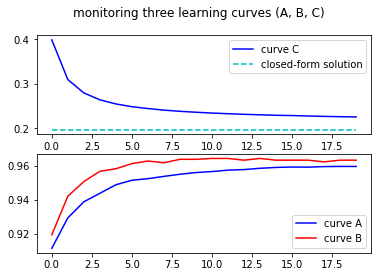

In [50]:
import matplotlib.pyplot as plt

reg = Ridge(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20,alpha=0.01)

w, A, B, C = ridge_regression_gd2(X_train, y_train, X_test, y_test, reg)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

epoch=0: the mean square error is 0.235 (0.957,0.963)
epoch=1: the mean square error is 0.224 (0.960,0.965)
epoch=2: the mean square error is 0.220 (0.960,0.963)
epoch=3: the mean square error is 0.217 (0.961,0.962)
epoch=4: the mean square error is 0.217 (0.962,0.962)
epoch=5: the mean square error is 0.214 (0.963,0.963)
epoch=6: the mean square error is 0.214 (0.962,0.963)
epoch=7: the mean square error is 0.213 (0.963,0.965)
epoch=8: the mean square error is 0.211 (0.964,0.963)
epoch=9: the mean square error is 0.211 (0.964,0.962)


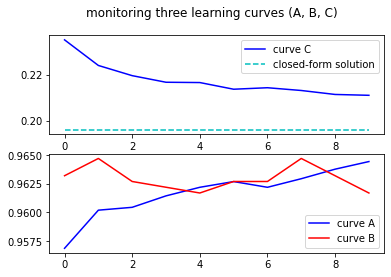

In [51]:
import matplotlib.pyplot as plt

reg = Ridge(lr=0.001, annealing_rate=0.99, batch_size=5, max_epochs=10,alpha=0.01)

w, A, B, C = ridge_regression_gd2(X_train, y_train, X_test, y_test, reg)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

### **Problem 2.2:**

Use LASSO to solve the regression problem in Example 2.1 as well as the classification problem in Example 2.2, compare the results of LASSO with those of linear regression and Ridge regression.

Finally, let us show how to solve the above ridge regression problem using the scikit-learning implmenetation. 

In [72]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
lasso_regr = linear_model.Lasso(alpha=0.001)

# Train the model using the training set
lasso_regr.fit(data_wb, target)

# Make predictions using the same training set
predict = lasso_regr.predict(data_wb)

# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(target, predict))

Mean squared error: 21.89490


## **II. Linear Regression for Classification**

### **Problem 2.2:**

Use lasso regression to build a binary classifier to classify two digits ('3' and '8') in the MNIST data set. .

In [81]:
# use ridge regression from sklearn

import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create ridge regression object
lass_regr = linear_model.Lasso(alpha=0.001)

# Train the model using the training set
lass_regr.fit(X_train, y_train)

# Make predictions using the same training set
predict = lass_regr.predict(X_train)
print("Mean squared error on training data: %.5f" % mean_squared_error(y_train, predict))

# Make predictions using the test set
predict = lass_regr.predict(X_test)
print("Mean squared error on test data: %.5f" % mean_squared_error(y_test, predict))

Mean squared error on training data: 0.20227
Mean squared error on test data: 0.21620
